<a href="https://colab.research.google.com/github/ollihansen90/ChaBoDoc_Chatbot/blob/main/ChatBot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ChaBoDoc-Chatbot

## Importiere Zeugs

In [17]:
import sys, os
# Lade 
if "google.colab" in sys.modules:
    if os.getcwd() == "/content":
        !git clone "https://github.com/ollihansen90/ChaBoDoc_Chatbot.git"
        os.chdir("ChaBoDoc_Chatbot")

# Importiere PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F

# Importiere Plot-Zeugs
import matplotlib.pyplot as plt

# Natural Language Toolkit
import nltk
from nltk.stem.lancaster import LancasterStemmer
nltk.download('punkt')

# Initialisiere Stemmer
STEMMER = LancasterStemmer()

# Herzstück für das Textverständnis
def bagofwords(s, words):
    # Input: Satz s (User-Input), Liste bekannter Wörter words
    # Output: Vektor mit Nullen und Einsen
    bag = [0 for _ in range((len(words)))]
    s_words = nltk.word_tokenize(s) # Splitte Satz auf in einzelne Wörter und Satzzeichen
    s_words = [STEMMER.stem(word.lower()) for word in s_words] # "Kürze" Wörter gemäß Lancaster-Stemmer
    print(s_words)

    # Wenn Wort in Wortliste enthalten, setze 1, sonst 0
    for se in s_words:
        for i, w in enumerate(words):
            if w==se:
                bag[i] = 1
        
    return torch.tensor(bag).float() 

print(bagofwords("Hallo, mein Name ist Olli", ["hallo", "oll"][::-1]))

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
['hallo', ',', 'mein', 'nam', 'ist', 'oll']
tensor([1., 1.])
cuda


## Datenverarbeitung und Vorbereitung

In [18]:
import json
from stopwords import worte

with open("intents.json") as file:
    data = json.load(file)

words = []  # Wörter, die der Chatbot erkennen können soll
labels = [] # zugehörige Labels (siehe Output unten)
docs_x = [] # Trainingsgedöhns
docs_y = []

# Durchlaufe die Intents
for intent in data["intents"]:
    # Speichere Pattern-Token (gekürzte Wörter) mit zugehörigen Labeln
    for pattern in intent["patterns"]:
        wrds = nltk.word_tokenize(pattern)
        words.extend(wrds)
        docs_x.append(wrds)
        docs_y.append(intent["tag"])
    
    if intent["tag"] not in labels:
        labels.append(intent["tag"])

"""print(words)
print(labels)
print(docs_x)
print(docs_y)"""

words = [w for w in words if not w in worte] # Schmeiße Stopwords raus (sowas wie "als" oder "habe"), die irrelevant für die Klassifizierung sind
words = [STEMMER.stem(w.lower()) for w in words if w != "?"]
words = sorted(list(set(words)))
labels = sorted(labels)
print(labels)

training = []
output = []

out_empty = [0 for _ in range(len(labels))]


# Generiere training und output für Training des Chatbots
for x, doc in enumerate(docs_x):
    bag = []
    wrds = [STEMMER.stem(w.lower()) for w in doc]

    for w in words:
        if w in wrds:
            bag.append(1)
        else:
            bag.append(0)

    output_row = out_empty[:]
    output_row[labels.index(docs_y[x])] = 1
    training.append(bag)
    output.append(output_row)

training = torch.tensor(training).float().to(device)
output = torch.tensor(output).float().to(device)

['Corona', 'Uni', 'age', 'bad words', 'good words', 'goodbye', 'greeting', 'help', 'hobby', 'hours', 'name', 'neutral words', 'prak', 'sleep']


## "Gehirn"

In [35]:
# Hier sollen die Studierenden rumspielen.
# Aktuell: Ein MLP mit einem Layer und ohne Aktivierungsfunktion
class Classifier(nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.layer1 = nn.Linear(dim_in, dim_out)
    
    def forward(self, x):
        out = self.layer1(x)
        return out

dim_in = len(training[0])
dim_out = len(output[0])
model = Classifier(dim_in, dim_out).to(device)

print(dim_in, dim_out)

507 14


## Training "Gehirn"

torch.Size([525, 507]) torch.Size([525, 14])
0 2.6438634395599365
100 2.281384229660034
200 1.961513876914978
300 1.6856215000152588
400 1.450934648513794
500 1.2524813413619995
600 1.084957242012024
700 0.9435493350028992
800 0.8241119384765625
900 0.7231124639511108
1000 0.6375419497489929
1100 0.5648451447486877
1200 0.5028663277626038
1300 0.4498037099838257
1400 0.40416374802589417
1500 0.364716112613678
1600 0.3304513096809387
1700 0.30054202675819397
1800 0.27430960536003113
1900 0.2511962950229645
2000 0.23074188828468323
2100 0.21256518363952637
2200 0.19634900987148285
2300 0.181828111410141
2400 0.16877976059913635
2500 0.15701603889465332
2600 0.1463775634765625
2700 0.13672874867916107
2800 0.12795360386371613
2900 0.11995261162519455
3000 0.11263994127511978
3100 0.10594133287668228
3200 0.09979227185249329
3300 0.09413648396730423
3400 0.08892470598220825
3500 0.084113709628582
3600 0.07966534048318863
3700 0.07554587721824646
3800 0.07172540575265884
3900 0.068177312612

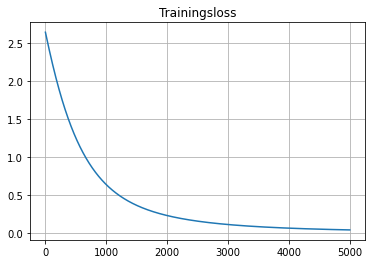

In [36]:
# Trainiere das Chatbot-Gehirn
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = F.cross_entropy

n_epochs = 5000
lossliste = torch.zeros(n_epochs)

print(training.shape, output.shape)
# Da der Datensatz nur 525 Einträge enthält, brauchen wir keine Batches und können komplett trainieren
for epoch in range(n_epochs):
    optimizer.zero_grad()
    out = model(training)
    loss = loss_func(out, output)
    loss.backward()
    optimizer.step()
    lossliste[epoch] = loss.item()
    if epoch%100==0:
        print(epoch, loss.item())

# Plotte Loss-Verlauf
plt.figure()
plt.plot(lossliste.cpu().numpy())
plt.title("Trainingsloss")
plt.grid()
plt.show()


## Verarbeite Input

In [37]:
from random import choice

# Wende Chatbot-Gehirn auf Nachricht an
def predict(message, model, words, labels, data):
    message = message.lower()
    result = F.softmax(model(bagofwords(message, words).to(device)), dim=0)
    result_index = torch.argmax(result)
    tag = labels[result_index]

    # Wie sicher ist sich der Chatbot? 0.9 ist schon ziemlich sicher.
    if result[result_index] > 0.9:
        for tg in data["intents"]:
            if tg["tag"] == tag:
                responses = tg["responses"]
        response = choice(responses)
    else:
        print("Chatbot ist sich etwas unsicher.", result[result_index].item())
        response = "Come again for Big Fudge?"
    return tag, response

## Verständnistest

In [38]:
# Versetze Modell in Evaluationsmodus
model.eval()

# Interaktion 1: Begrüßung
print("Chatbot:", "Hallo :-)")
user_input = input("User:    ")
tag, response = predict(user_input, model, words, labels, data)
print("Chatbot glaubt, das Label ist", tag)
print("Chatbot:", response)

# Interaktion 2: Whaddup
print("Chatbot:", "Wie geht es dir?")
user_input = input("User:    ")
tag, response = predict(user_input, model, words, labels, data)
print("Chatbot glaubt, das Label ist", tag)
print("Chatbot:", response)

# Interaktion 3: Verabschiedung
print("Chatbot:", "Ich muss jetzt leider gehen... Auf Wiedersehen :-)")
user_input = input("User:    ")
tag, response = predict(user_input, model, words, labels, data)
print("Chatbot glaubt, das Label ist", tag)
print("Chatbot:", response)

Chatbot: Hallo :-)
User:    Huhu
['huhu']
Chatbot glaubt, das Label ist greeting
Chatbot: Hi, wie kann ich Dir helfen?
Chatbot: Wie geht es dir?
User:    Gut, und dir?
['gut', ',', 'und', 'dir', '?']
Chatbot glaubt, das Label ist goodbye
Chatbot: Bis bald dann mal!
Chatbot: Ich muss jetzt leider gehen... Auf Wiedersehen :-)
User:    Bis dann
['bis', 'dan']
Chatbot glaubt, das Label ist goodbye
Chatbot: Bis bald dann mal!


# Alte Tests

In [ ]:
import json
import urllib.request
with urllib.request.urlopen("https://raw.githubusercontent.com/inb-luebeck/chat_bot/main/Melinda/intents.json?token=GHSAT0AAAAAABQNOK46CRADPTF4EY5NRSGWYO4D7XA") as file:
    data = json.loads(file.read().decode())
print(data)

HTTPError: ignored

In [ ]:
import pickle
import cloudpickle as cp

loaded_pickle_object = cp.load(urllib.request.urlopen("https://github.com/inb-luebeck/chat_bot/blob/main/Melinda/model/data.pickle?raw=true", "rb"))
print(loaded_pickle_object)


TypeError: ignored